In [1]:
library(rstatix)
library(readr)
# library(lme4)
library(afex)
library(performance)
library(RCurl)
library(optimx)
library(parallel)
library(minqa)
library(ggpubr)
library(ez) 
library(tidyverse)
# https://github.com/mike-lawrence/ez

Warning message:
“package ‘rstatix’ was built under R version 4.0.3”

Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter


Warning message:
“package ‘readr’ was built under R version 4.0.5”
Warning message:
“package ‘afex’ was built under R version 4.0.5”
Loading required package: lme4

Warning message:
“package ‘lme4’ was built under R version 4.0.5”
Loading required package: Matrix

Warning message:
“package ‘Matrix’ was built under R version 4.0.5”
************
Welcome to afex. For support visit: http://afex.singmann.science/

- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'S', 'KR', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- NEWS: emmeans() for ANOVA models now uses model = 'multivariate' as default.
- Get and set global package options with: afex_options()
- Set orthogonal sum-to-zero contrasts globally: set_sum_contrasts()


# Forced-choice survey LMER

In [2]:
df = read_csv("../clean_data/forced_choice_emotion_uw_students_long_format_lmer.csv")


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  participantId = col_double(),
  photoId = col_character(),
  emotion = col_character(),
  ethnicity = col_character(),
  sex = col_character(),
  age = col_character(),
  label = col_character(),
  url = col_character(),
  sentimentScore = col_double(),
  sexC = col_double(),
  ageC = col_double(),
  ethnicityC = col_double()
)




## Useful links about fitting LMER 
- https://bbolker.github.io/mixedmodels-misc/glmmFAQ.html#singular-models-random-effect-variances-estimated-as-zero-or-correlations-estimated-as---1
- https://stats.stackexchange.com/questions/242109/model-failed-to-converge-warning-in-lmer
- https://easystats.github.io/blog/posts/performance_check_collinearity/
- https://stats.stackexchange.com/questions/449042/is-a-singular-fit-with-no-correlations-near-1-or-variances-of-zero-a-false
- http://svmiller.com/blog/2018/06/mixed-effects-models-optimizer-checks/
- https://joshua-nugent.github.io/allFit/
- https://rstudio-pubs-static.s3.amazonaws.com/33653_57fc7b8e5d484c909b615d8633c01d51.html
- https://stats.stackexchange.com/questions/323273/what-to-do-with-random-effects-correlation-that-equals-1-or-1
- https://psych.wisc.edu/Brauer/BrauerLab/wp-content/uploads/2014/04/Brauer-and-Curtin-in-press-Psych-Methods.pdf
- https://cran.r-project.org/web/packages/lme4/vignettes/lmerperf.html
- https://rpubs.com/palday/lme4-singular-convergence

## Run model with Nelder-Mead opt

**Determining random effect structure**

**Random Intercept**:
- participantId: repeated measures from same participant
- photoId: repeated measures from same photo

**Random slope**:
- ethnicity: varies *within participantId* and *between items*
- sex: varies *within participantId* and *between items*
- age: varies *within participantId* and *between items*

----
- Random intercept and slope for participantId
- Random intercept for photoId

----

In [3]:
# ---------
# doesn't converge
# ---------

# lmer_fc_uw_max = lmer(
#     sentimentScore ~ 1 + sexC*ethnicityC*ageC + (1 + sexC*ethnicityC*ageC|participantId) + (1 | photoId), 
#     data = df, 
#     REML = FALSE, 
#     control = lmerControl(optimizer ="Nelder_Mead", calc.derivs=FALSE)
# )
# summary(lmer_fc_uw_max)

In [4]:
# -------------
# lacks power because there is only 1 obs per cell of [participantId X photoId]
# -------------

lmer_fc_uw_full = lmer(
    sentimentScore ~ 1 + sexC*ethnicityC + (1 + sexC*ethnicityC|participantId) + (1 | photoId), 
    data = df, 
    REML = FALSE, 
    control = lmerControl(optimizer ="Nelder_Mead", calc.derivs=FALSE)
)
summary(lmer_fc_uw_full)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: sentimentScore ~ 1 + sexC * ethnicityC + (1 + sexC * ethnicityC |  
    participantId) + (1 | photoId)
   Data: df
Control: lmerControl(optimizer = "Nelder_Mead", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  2049.7   2164.7  -1008.9   2017.7     9776 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1517 -0.4843  0.0146  0.4421  4.5059 

Random effects:
 Groups        Name            Variance  Std.Dev. Corr             
 photoId       (Intercept)     1.034e-01 0.321522                  
 participantId (Intercept)     1.080e-03 0.032865                  
               sexC            9.943e-06 0.003153 -0.36            
               ethnicityC      2.270e-05 0.004765 -0.21  0.59      
               sexC:ethnicityC 1.161e-03 0.034069  0.07 -0.95 -0.49
 Residual                      6.545e-02 0.255828                  
Number of obs: 97

In [5]:
# --------------
# it doesn't address photoId random effect, but it has better power 20+ obs per cell (i.e., participantId )
# --------------

lmer_fc_uw_partial = lmer(
    sentimentScore ~ 1 + sexC*ethnicityC + (1 + sexC*ethnicityC|participantId), 
    data = df, REML = FALSE, 
    control = lmerControl(optimizer ="Nelder_Mead", calc.derivs=FALSE)
)
summary(lmer_fc_uw_partial)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: sentimentScore ~ 1 + sexC * ethnicityC + (1 + sexC * ethnicityC |  
    participantId)
   Data: df
Control: lmerControl(optimizer = "Nelder_Mead", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
 10453.6  10561.5  -5211.8  10423.6     9777 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2719 -0.9327  0.1997  0.9007  1.7652 

Random effects:
 Groups        Name            Variance  Std.Dev.  Corr             
 participantId (Intercept)     5.006e-04 0.0223734                  
               sexC            1.391e-06 0.0011792 -1.00            
               ethnicityC      7.550e-07 0.0008689 -0.99  0.99      
               sexC:ethnicityC 6.703e-06 0.0025890  0.86 -0.86 -0.84
 Residual                      1.694e-01 0.4115362                  
Number of obs: 9792, groups:  participantId, 51

Fixed effects:
                  Estimate Std.

## Check collinearity

In [6]:
# check_collinearity(lmer_fc_uw_full)

In [7]:
check_collinearity(lmer_fc_uw_partial)

,Term,VIF,SE_factor
,<chr>,<dbl>,<dbl>
1,sexC,1,1
2,ethnicityC,1,1
3,sexC:ethnicityC,1,1


In [8]:
# plot(check_collinearity(lmer_fc_uw_full))

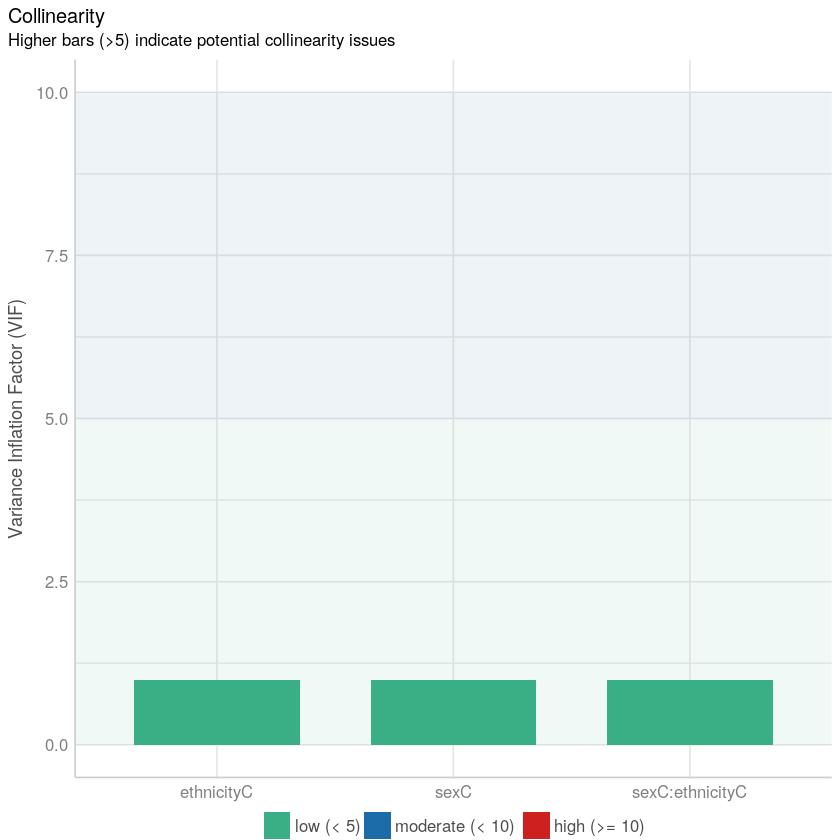

In [9]:
plot(check_collinearity(lmer_fc_uw_partial))

## Check singularity

In [10]:
# https://rstudio-pubs-static.s3.amazonaws.com/33653_57fc7b8e5d484c909b615d8633c01d51.html

# tt = getME(lmer_fc_uw_full,"theta")
# ll = getME(lmer_fc_uw_full,"lower")
# tt_value = min(tt[ll==0])

# https://rstudio-pubs-static.s3.amazonaws.com/33653_57fc7b8e5d484c909b615d8633c01d51.html
tt_p = getME(lmer_fc_uw_partial,"theta")
ll_p = getME(lmer_fc_uw_partial,"lower")
tt_value_p = min(tt_p[ll_p==0])

tt_value_p

[1] 0.000128365

In [11]:
tt_value_p < 0.000001
# probably not a problem

[1] FALSE

In [12]:
theta_p <- getME(lmer_fc_uw_partial,"theta")
## diagonal elements are identifiable because they are fitted
##  with a lower bound of zero ...
diag.element <- getME(lmer_fc_uw_partial,"lower")==0
any(theta_p[diag.element]<1e-5)

# probably not a problem

[1] FALSE

## Testing multiple optimizers


In [13]:
# lmer_fc_uw_m = lmer(sentimentScore ~ 1 + sexC*ethnicityC + (1 + sexC*ethnicityC|participantId), data = df)

In [14]:
# ncores <- detectCores()
# diff_optims <- allFit(lmer_fc_uw_m, maxfun = 1e5, parallel = 'multicore', ncpus = ncores)

In [15]:
# is.OK <- sapply(diff_optims, is, "merMod")
# diff_optims.OK <- diff_optims[is.OK]
# lapply(diff_optims.OK,function(x) x@optinfo$conv$lme4$messages)

In [16]:
# (lliks <- sort(sapply(diff_optims.OK,logLik)))

## Three-way Anova 

### Useful links about fitting ANOVAS
- https://www.datanovia.com/en/lessons/repeated-measures-anova-in-r/
- https://cran.r-project.org/web/packages/effectsize/vignettes/anovaES.html
- https://rpkgs.datanovia.com/rstatix/reference/anova_test.html
- https://stats.stackexchange.com/questions/11079/problem-with-anova-repeated-measures-error-model-is-singular

### Descriptives

In [17]:
df %>%
  group_by(ethnicity, sex, age) %>%
  get_summary_stats(sentimentScore, type = "mean_sd")

ethnicity,sex,age,variable,n,mean,sd
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
bipoc,female,adult,sentimentScore,1224,-0.134,0.417
bipoc,female,child,sentimentScore,1224,-0.089,0.418
bipoc,male,adult,sentimentScore,1224,-0.175,0.406
bipoc,male,child,sentimentScore,1224,-0.121,0.416
white,female,adult,sentimentScore,1224,-0.118,0.410
white,female,child,sentimentScore,1224,-0.089,0.412
white,male,adult,sentimentScore,1224,-0.094,0.395
white,male,child,sentimentScore,1224,-0.104,0.420


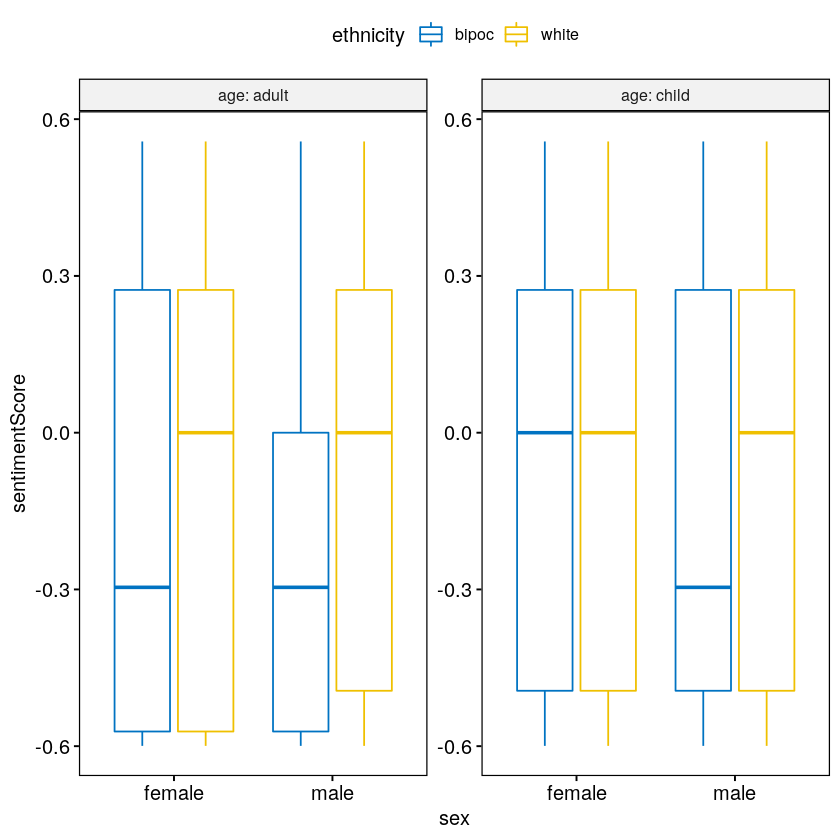

In [18]:
# bxp <- ggboxplot(
#   df, x = "ethnicity", y = "sentimentScore",
#   color = "sex", palette = "jco",
#   facet.by = "age", short.panel.labs = FALSE,
#   scales = "free"
#   )
# bxp

bxp <- ggboxplot(
  df, x = "sex", y = "sentimentScore",
  color = "ethnicity", palette = "jco",
  facet.by = "age", short.panel.labs = FALSE,
  scales = "free"
  )
bxp

### Check assumptions

#### Outliers

In [19]:
df %>% group_by(ethnicity, sex, age) %>% identify_outliers(sentimentScore)

# no outliers

ethnicity,sex,age,participantId,photoId,emotion,label,url,sentimentScore,sexC,ageC,ethnicityC,is.outlier,is.extreme
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>


#### Normality assumption

In [20]:
# Compute Shapiro-Wilk test for each combinations of factor levels

df %>%
  group_by(ethnicity, sex, age) %>%
  shapiro_test(sentimentScore)

ethnicity,sex,age,variable,statistic,p
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
bipoc,female,adult,sentimentScore,0.8573349,6.875608e-32
bipoc,female,child,sentimentScore,0.8650087,3.461563e-31
bipoc,male,adult,sentimentScore,0.8444974,5.333350e-33
bipoc,male,child,sentimentScore,0.8590749,9.858681e-32
white,female,adult,sentimentScore,0.8656738,3.995529e-31
white,female,child,sentimentScore,0.8739884,2.521951e-30
white,male,adult,sentimentScore,0.8864712,4.836086e-29
white,male,child,sentimentScore,0.8626490,2.089945e-31


In [21]:
3.461563e-31 < 0.05

# not normal

[1] TRUE

#### QQ plot 

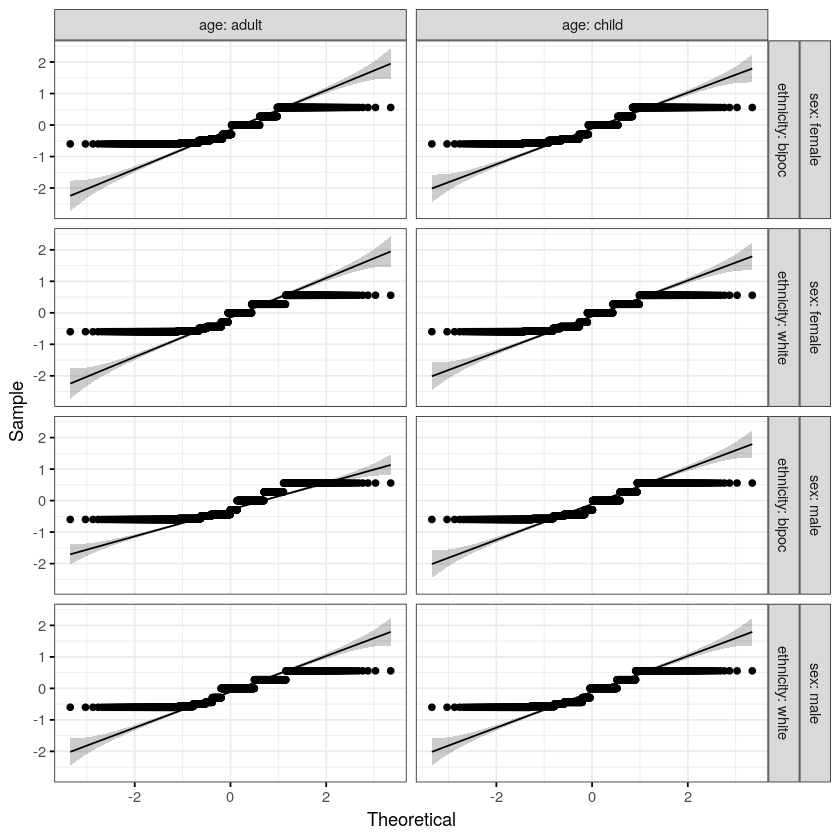

In [22]:
ggqqplot(df, "sentimentScore", ggtheme = theme_bw()) +
  facet_grid(sex + ethnicity ~ age, labeller = "label_both")

**Definetively not normal data**

## Anova 2x2x2 computation 


My design is 2x2x2 fully-crosses, meaning will yield a singular decomposition. 
This is probably why LMER doesn't converge regardless of the optimizer and other hyper-params

Guide: https://www.datanovia.com/en/lessons/repeated-measures-anova-in-r/#summary-statistics-2

In [23]:
df_long = df %>% select(participantId, sex, age, ethnicity, sentimentScore)

In [24]:
df_long = df_long %>% convert_as_factor(participantId, sex, age, ethnicity)

In [25]:
head(df_long)

participantId,sex,age,ethnicity,sentimentScore
<fct>,<fct>,<fct>,<fct>,<dbl>
0,female,adult,bipoc,0.0000
0,male,child,white,0.5574
0,male,adult,bipoc,-0.5994
0,male,child,bipoc,-0.5994
0,male,adult,white,0.5574
0,female,adult,white,-0.2960


In [26]:
# res.aov <- anova_test(
#   data = df_long, dv = sentimentScore, wid = participantId,
#   within = c(sex, age, ethnicity)
#   )
# get_anova_table(res.aov)

In [27]:
res.aov  = ezANOVA(data=df, wid=.(participantId), dv=.(sentimentScore), within=.(sex, age, ethnicity))
res.aov  

Warning message:
“Converting "participantId" to factor for ANOVA.”
Warning message:
“Converting "sex" to factor for ANOVA.”
Warning message:
“Converting "age" to factor for ANOVA.”
Warning message:
“Converting "ethnicity" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”


,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,sex,1,50,9.521419,3.306335e-03,*,0.016548360
3,age,1,50,21.604378,2.475379e-05,*,0.054099828
4,ethnicity,1,50,31.530648,8.618142e-07,*,0.051307750
5,sex:age,1,50,2.852944,9.743446e-02,,0.003967705
6,sex:ethnicity,1,50,13.324762,6.258531e-04,*,0.026661649
7,age:ethnicity,1,50,19.737606,4.929783e-05,*,0.025649119
8,sex:age:ethnicity,1,50,5.194152,2.696674e-02,*,0.009402510


In [28]:
format(2.696674e-02, scientific=FALSE)

[1] "0.02696674"

There is a statistically significant three-way interactions between age, sex, and ethnicity, Anova, $F$(1, 50) = 5.19, $p$ = 0.03, $\eta^2_{g}=0.009$

### Post-hoc tests

https://www.datanovia.com/en/lessons/repeated-measures-anova-in-r/#post-hoc-tests-2

A significant three-way interaction effect can be decomposed into:

- Simple two-way interaction: run two-way interaction at each level of third variable,
- Simple main effect: run one-way model at each level of second variable, and
- Simple pairwise comparisons: run pairwise or other post-hoc comparisons if necessary.

#### Simple two-way interaction

In [29]:
df_adult = df %>% filter(age=='adult')
df_child = df %>% filter(age=='child')

In [30]:
adult.twoway  = ezANOVA(data=df_adult, wid=.(participantId), dv= .(sentimentScore), within=.(sex, ethnicity))
child.twoway  = ezANOVA(data=df_child, wid=.(participantId), dv= .(sentimentScore), within=.(sex, ethnicity))

Warning message:
“Converting "participantId" to factor for ANOVA.”
Warning message:
“Converting "sex" to factor for ANOVA.”
Warning message:
“Converting "ethnicity" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”
Warning message:
“Converting "participantId" to factor for ANOVA.”
Warning message:
“Converting "sex" to factor for ANOVA.”
Warning message:
“Converting "ethnicity" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”


In [31]:
adult.twoway

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,sex,1,50,1.490899,2.278037e-01,,0.004790347
3,ethnicity,1,50,45.074712,1.683223e-08,*,0.144664819
4,sex:ethnicity,1,50,13.878048,4.966296e-04,*,0.069780059


In [32]:
child.twoway

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,sex,1,50,11.094252,0.001633397,*,0.033331676
3,ethnicity,1,50,1.872582,0.177297353,,0.004563006
4,sex:ethnicity,1,50,1.664337,0.202953640,,0.004279434


There is statistically significant simple two-way interaction between **sex** and **ethnicity** for "adults", F(1, 50) = 13.88, p < 0.0001, but not for "childrens" , F(1, 50) = 1.66, p = 0.2.

#### Simple main effects

In [33]:
df_adult_male = df_adult %>% filter(sex=='male')
df_child_female = df_child %>% filter(sex=='female')

In [34]:
adult_male.main  = ezANOVA(data=df_adult_male, wid=.(participantId), dv= .(sentimentScore), within=.(ethnicity))
adult_female.main  = ezANOVA(data=df_child_female, wid=.(participantId), dv= .(sentimentScore), within=.(ethnicity))

Warning message:
“Converting "participantId" to factor for ANOVA.”
Warning message:
“Converting "ethnicity" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”
Warning message:
“Converting "participantId" to factor for ANOVA.”
Warning message:
“Converting "ethnicity" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”


In [35]:
adult_male.main

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,ethnicity,1,50,43.14119,2.843831e-08,*,0.3085971


In [36]:
adult_female.main

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,ethnicity,1,50,0.0009107473,0.9760448,,4.669057e-06


There is a statistically significant simple main effect of **ethnicity** on **sentiment-score** for the "**adult-males**" group F(1, 50) = 43.14, p < 0.0001, but not for the "adult-female" group.

#### Simple Pairwise comparisons

In [37]:
pwc <- df %>%
  group_by(age, sex) %>%
  pairwise_t_test(sentimentScore ~ ethnicity, paired = TRUE, p.adjust.method = "holm") %>%
  select(-df, -statistic) # Remove details

pwc

sex,age,.y.,group1,group2,n1,n2,p,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>
female,adult,sentimentScore,bipoc,white,1224,1224,3.34e-01,3.34e-01,ns
male,adult,sentimentScore,bipoc,white,1224,1224,8.88e-07,8.88e-07,****
female,child,sentimentScore,bipoc,white,1224,1224,9.87e-01,9.87e-01,ns
male,child,sentimentScore,bipoc,white,1224,1224,2.97e-01,2.97e-01,ns


In [38]:
pwc %>% filter(sex == "male", age == "adult") %>%
  select(-p)     # remove p columns

sex,age,.y.,group1,group2,n1,n2,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>
male,adult,sentimentScore,bipoc,white,1224,1224,8.88e-07,****


### Visualization forced-choice: box plots with p-values

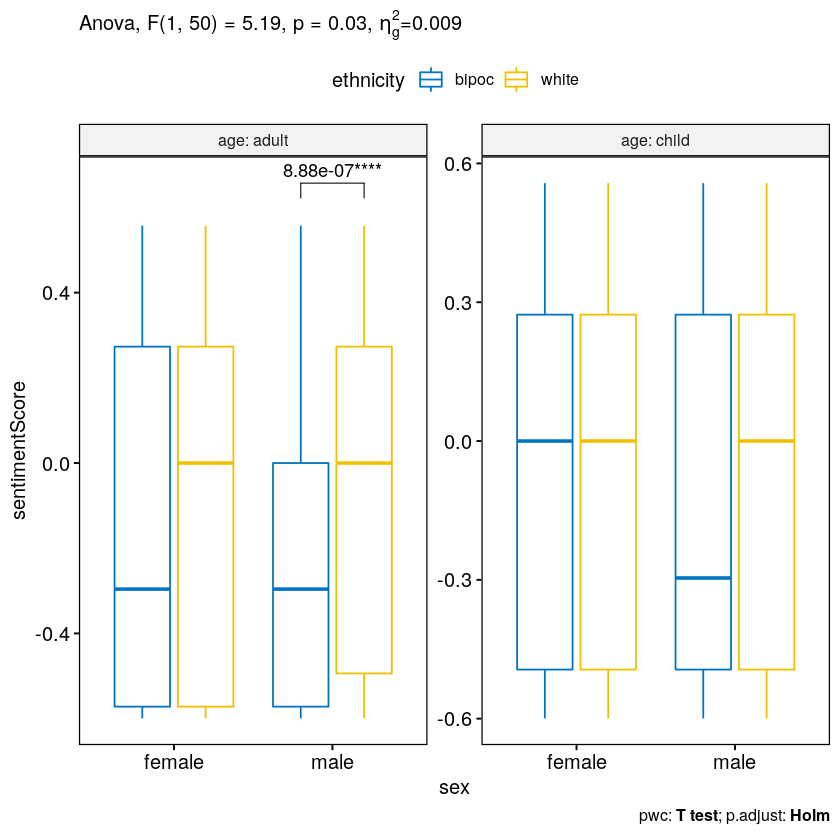

In [39]:
# subtitle_3way_anova = "Anova, $F$(1, 50) = 5.19, $p$ = 0.03, $\\eta^2_{g}=0.009$"
subtitle_3way_anova = expression(paste("Anova, F(1, 50) = 5.19, p = 0.03, ",eta[g]^2, "=0.009"))
pwc <- pwc %>% add_xy_position(x = "sex")

bxp +  
  stat_pvalue_manual(
    pwc, hide.ns = TRUE, bracket.nudge.y = 0.1,
    label = "{p.adj}{p.adj.signif}"
    ) +
  labs(
    subtitle = subtitle_3way_anova,
    caption = get_pwc_label(pwc)
  )

In [40]:
ggsave("../clean_data/anova_3way_test_forced_choice.png")
ggsave("../../emotions_dashboard/data/anova_3way_test_forced_choice.png")

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



## Report

-------------------




***PENDING...***



-------------------

## Anova agrgegated across ethnicity for between-effect

In [41]:
mDf = aggregate(sentimentScore ~ participantId + ethnicityC, data=df, FUN=mean)

In [42]:
summary(aov(sentimentScore ~ ethnicityC, data=mDf))     # ANOVA with just the between-effect

             Df  Sum Sq  Mean Sq F value   Pr(>F)    
ethnicityC    1 0.02102 0.021020   12.05 0.000764 ***
Residuals   100 0.17436 0.001744                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [43]:
# Images depicting caucasian faces 

In [44]:
mDf %>%
  group_by(ethnicityC) %>%
  get_summary_stats(sentimentScore, type = "mean_sd")

ethnicityC,variable,n,mean,sd
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
-0.5,sentimentScore,51,-0.130,0.042
0.5,sentimentScore,51,-0.101,0.041


In [45]:
-0.130 - (-0.101)

[1] -0.029

# Free-labeling

In [46]:
df_free = read_csv("../clean_data/free_labeling_emotion_uw_students_long_format_lmer.csv")


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  participantId = col_double(),
  photoId = col_character(),
  emotion = col_character(),
  ethnicity = col_character(),
  sex = col_character(),
  age = col_character(),
  label = col_character(),
  url = col_character(),
  sentimentScore = col_double(),
  sexC = col_double(),
  ageC = col_double(),
  ethnicityC = col_double()
)




In [47]:
dim(df_free)

[1] 14609    12

## Run model with Nelder-Mead opt

**Determining random effect structure**

**Random Intercept**:
- participantId: repeated measures from same participant
- photoId: repeated measures from same photo

**Random slope**:
- ethnicity: varies *within participantId* and *between items*
- sex: varies *within participantId* and *between items*
- age: varies *within participantId* and *between items*

----
- Random intercept and slope for participantId
- Random intercept for photoId

----

## Check outlier 

In [48]:
df_free_outliers = df_free %>% group_by(ethnicity, sex, age) %>% identify_outliers(sentimentScore)
df_free_outliers

ethnicity,sex,age,participantId,photoId,emotion,label,url,sentimentScore,sexC,ageC,ethnicityC,is.outlier,is.extreme
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
bipoc,male,adult,8,Q166.1_1,Care free,neutral,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_2ubTkbpnURV3shw,0.7579,0.5,0.5,-0.5,TRUE,FALSE


In [49]:
## remove outlier
df_free = df_free %>% 
  anti_join(df_free_outliers, by = c("participantId", "photoId"))


dim(df_free)

[1] 14608    12

In [50]:
# -------------
# lacks power because there is only 1 obs per cell of [participantId X photoId]
# -------------

lmer_fl_uw_full = lmer(
    sentimentScore ~ 1 + sexC*ethnicityC + (1 + sexC*ethnicityC|participantId) + (1 | photoId), 
    data = df_free,
    REML = FALSE, 
    control = lmerControl(optimizer ="Nelder_Mead", calc.derivs=FALSE)
)
summary(lmer_fl_uw_full)

Warning message:
“Model failed to converge with 1 negative eigenvalue: -4.3e+01”


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: sentimentScore ~ 1 + sexC * ethnicityC + (1 + sexC * ethnicityC |  
    participantId) + (1 | photoId)
   Data: df_free
Control: lmerControl(optimizer = "Nelder_Mead", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  4308.8   4430.2  -2138.4   4276.8    14592 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7953 -0.6515 -0.0998  0.6182  4.2449 

Random effects:
 Groups        Name            Variance Std.Dev. Corr             
 photoId       (Intercept)     0.047379 0.21767                   
 participantId (Intercept)     0.050304 0.22429                   
               sexC            0.006708 0.08191   0.93            
               ethnicityC      0.001525 0.03906  -0.65 -0.77      
               sexC:ethnicityC 0.077643 0.27865   0.95  0.97 -0.70
 Residual                      0.068005 0.26078                   
Number of obs: 1460

In [51]:
# --------------
# it doesn't address photoId random effect, but it has better power 20+ obs per cell (i.e., participantId )
# Also, I specified multiple uncorrelated random effects for the same grouping variable, so the model converge
# --------------

lmer_fl_uw_partial = lmer(
    sentimentScore ~ 1 + sexC*ethnicityC + (1 + sexC*ethnicityC||participantId), 
    data = df_free, 
    REML = FALSE, 
    control = lmerControl(optimizer ="Nelder_Mead", calc.derivs=FALSE)
)
summary(lmer_fl_uw_partial)

Warning message:
“Model failed to converge with 1 negative eigenvalue: -2.2e+03”


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: sentimentScore ~ 1 + sexC * ethnicityC + (1 + sexC * ethnicityC ||  
    participantId)
   Data: df_free
Control: lmerControl(optimizer = "Nelder_Mead", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
 11989.2  12057.5  -5985.6  11971.2    14599 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9328 -0.8813 -0.0320  0.6504  2.6003 

Random effects:
 Groups          Name            Variance  Std.Dev. 
 participantId   (Intercept)     3.166e-03 5.627e-02
 participantId.1 sexC            0.000e+00 0.000e+00
 participantId.2 ethnicityC      3.130e-04 1.769e-02
 participantId.3 sexC:ethnicityC 1.526e-10 1.235e-05
 Residual                        1.319e-01 3.632e-01
Number of obs: 14608, groups:  participantId, 49

Fixed effects:
                  Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)     -9.840e-02  8.702e-03  5.101e+01 -

## Check collinearity

In [52]:
check_collinearity(lmer_fl_uw_partial)

,Term,VIF,SE_factor
,<chr>,<dbl>,<dbl>
1,sexC,1.000080,1.000040
2,ethnicityC,1.000081,1.000040
3,sexC:ethnicityC,1.000003,1.000001


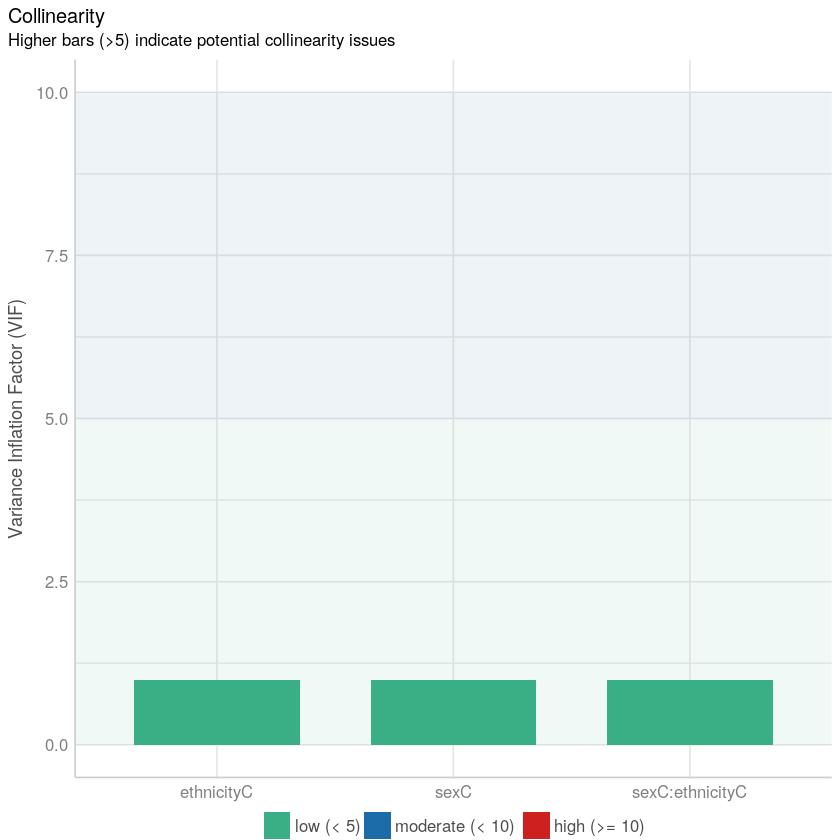

In [53]:
plot(check_collinearity(lmer_fl_uw_partial))

## Check singularity

In [54]:
check_collinearity(lmer_fl_uw_partial)

,Term,VIF,SE_factor
,<chr>,<dbl>,<dbl>
1,sexC,1.000080,1.000040
2,ethnicityC,1.000081,1.000040
3,sexC:ethnicityC,1.000003,1.000001


In [55]:
# https://rstudio-pubs-static.s3.amazonaws.com/33653_57fc7b8e5d484c909b615d8633c01d51.html


# https://rstudio-pubs-static.s3.amazonaws.com/33653_57fc7b8e5d484c909b615d8633c01d51.html
tt_p = getME(lmer_fl_uw_partial,"theta")
ll_p = getME(lmer_fl_uw_partial,"lower")
tt_value_p = min(tt_p[ll_p==0])

tt_value_p

[1] 0

In [56]:
theta_p <- getME(lmer_fl_uw_partial,"theta")
## diagonal elements are identifiable because they are fitted
##  with a lower bound of zero ...
diag.element <- getME(lmer_fl_uw_partial,"lower")==0
any(theta_p[diag.element]<1e-5)

# there may be a problem

[1] TRUE

## Three-way Anova 

In [57]:
df_free %>%
  group_by(ethnicity, sex, age) %>%
  get_summary_stats(sentimentScore, type = "mean_sd")

ethnicity,sex,age,variable,n,mean,sd
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
bipoc,female,adult,sentimentScore,1830,-0.101,0.373
bipoc,female,child,sentimentScore,1788,-0.057,0.388
bipoc,male,adult,sentimentScore,1864,-0.161,0.350
bipoc,male,child,sentimentScore,1831,-0.107,0.380
white,female,adult,sentimentScore,1845,-0.106,0.360
white,female,child,sentimentScore,1830,-0.094,0.369
white,male,adult,sentimentScore,1792,-0.100,0.347
white,male,child,sentimentScore,1828,-0.085,0.376


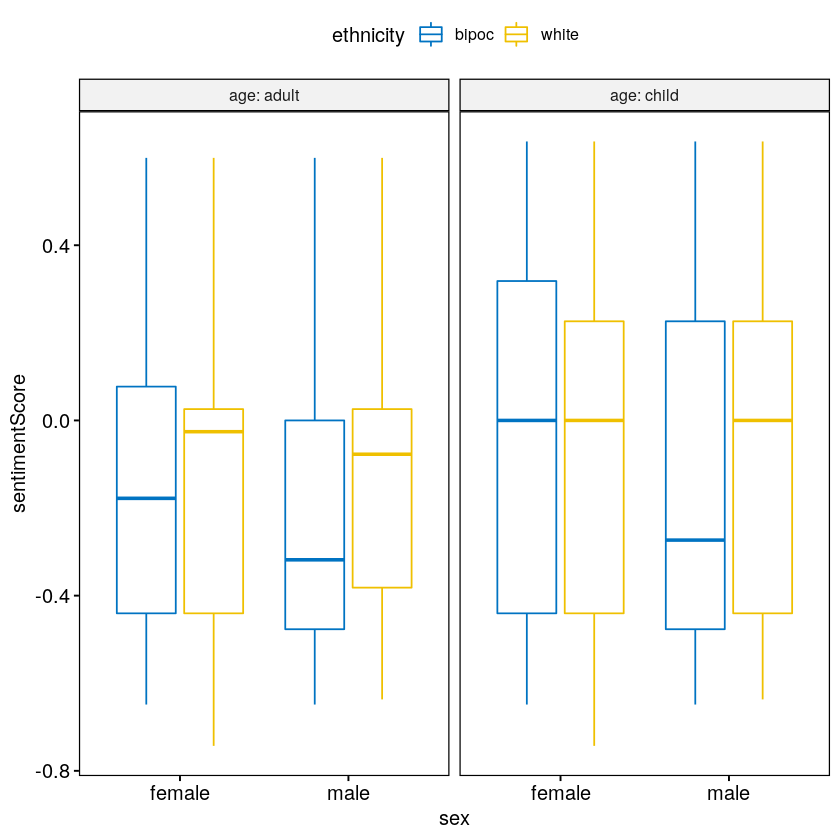

In [58]:
bxp_free <- ggboxplot(
  df_free, x = "sex", y = "sentimentScore",
  color = "ethnicity", palette = "jco",
  facet.by = "age", short.panel.labs = FALSE
  )
bxp_free

### Check assumptions

#### Outliers

In [59]:
df_free %>% group_by(ethnicity, sex, age) %>% identify_outliers(sentimentScore)
# just one not-extreme outlier

ethnicity,sex,age,participantId,photoId,emotion,label,url,sentimentScore,sexC,ageC,ethnicityC,is.outlier,is.extreme
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>


#### Normality assumption

In [60]:
# Compute Shapiro-Wilk test for each combinations of factor levels

df_free %>%
  group_by(ethnicity, sex, age) %>%
  shapiro_test(sentimentScore)

ethnicity,sex,age,variable,statistic,p
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
bipoc,female,adult,sentimentScore,0.8860512,1.012998e-34
bipoc,female,child,sentimentScore,0.8850780,1.709675e-34
bipoc,male,adult,sentimentScore,0.8727877,1.643614e-36
bipoc,male,child,sentimentScore,0.8738930,4.057388e-36
white,female,adult,sentimentScore,0.9000859,4.437113e-33
white,female,child,sentimentScore,0.8863609,1.102801e-34
white,male,adult,sentimentScore,0.9097998,2.462343e-31
white,male,child,sentimentScore,0.8893221,2.602755e-34


#### QQ plot 

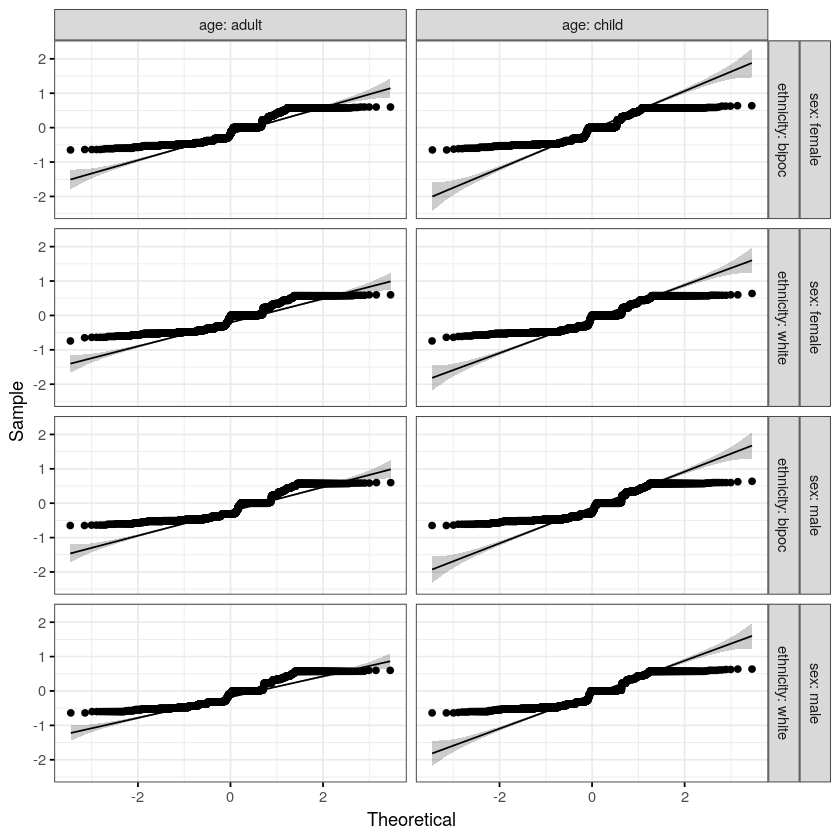

In [61]:
ggqqplot(df_free, "sentimentScore", ggtheme = theme_bw()) +
  facet_grid(sex + ethnicity ~ age, labeller = "label_both")

**Not normally distributed**

## Anova 2x2x2 computation 


In [62]:
df_long_free = df_free %>% select(participantId, sex, age, ethnicity, sentimentScore)
df_long_free = df_long_free %>% convert_as_factor(participantId, sex, age, ethnicity)
head(df_long_free)

participantId,sex,age,ethnicity,sentimentScore
<fct>,<fct>,<fct>,<fct>,<dbl>
0,female,adult,bipoc,-0.5106
0,male,child,bipoc,-0.2732
0,female,adult,white,-0.2732
0,male,adult,white,0.4404
0,female,child,white,-0.4404
0,male,adult,bipoc,-0.4767


In [63]:
res.aov  = ezANOVA(data=df_long_free, wid=.(participantId), dv=.(sentimentScore), within=.(sex, age, ethnicity))
res.aov  

Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”


,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,sex,1,48,13.6683723,5.597276e-04,*,0.018786932
3,age,1,48,35.0561460,3.311538e-07,*,0.055526313
4,ethnicity,1,48,1.1717051,2.844592e-01,,0.002096350
5,sex:age,1,48,2.6117540,1.126289e-01,,0.003598522
6,sex:ethnicity,1,48,51.8225186,3.647550e-09,*,0.047785369
7,age:ethnicity,1,48,7.5729868,8.335903e-03,*,0.010710563
8,sex:age:ethnicity,1,48,0.8052674,3.740022e-01,,0.001193078


The three-way interactions between age, sex, and ethnicity, was not significant, Anova, $F$(1, 48) = 0.80, $p$ = 0.3, $\eta^2_{g}=0.001$

### Post-hoc tests


#### simple two-way interaction

In [64]:
df_free_adult = df_free %>% filter(age=='adult')
df_free_child = df_free %>% filter(age=='child')

In [65]:
free_adult.twoway  = ezANOVA(data=df_free_adult, wid=.(participantId), dv= .(sentimentScore), within=.(sex, ethnicity))
free_child.twoway  = ezANOVA(data=df_free_child, wid=.(participantId), dv= .(sentimentScore), within=.(sex, ethnicity))

Warning message:
“Converting "participantId" to factor for ANOVA.”
Warning message:
“Converting "sex" to factor for ANOVA.”
Warning message:
“Converting "ethnicity" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”
Warning message:
“Converting "participantId" to factor for ANOVA.”
Warning message:
“Converting "sex" to factor for ANOVA.”
Warning message:
“Converting "ethnicity" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”


In [66]:
free_adult.twoway

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,sex,1,48,13.907215,5.071853e-04,*,0.03761892
3,ethnicity,1,48,7.252547,9.722303e-03,*,0.02180816
4,sex:ethnicity,1,48,19.287601,6.169337e-05,*,0.06222481


In [67]:
free_child.twoway

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,sex,1,48,2.240323,1.410000e-01,,0.006136523
3,ethnicity,1,48,1.012458,3.193604e-01,,0.003403745
4,sex:ethnicity,1,48,24.980396,8.115683e-06,*,0.034907984


There is statistically significant simple two-way interaction between **sex** and **ethnicity** for "adults", F(1, 48) = 19.28, p = 0.06,and for "childrens" , F(1, 48) = 24.98,  p = 0.04

#### Simple main effect

In [68]:
df_free_adult_male = df_free_adult %>% filter(sex=='male')
df_free_adult_female = df_free_adult %>% filter(sex=='female')
df_free_child_male = df_free_child %>% filter(sex=='male')
df_free_child_female = df_free_child %>% filter(sex=='female')

In [69]:
free_adult_male.main  = ezANOVA(data=df_free_adult_male, wid=.(participantId), dv= .(sentimentScore), within=.(ethnicity))
free_adult_female.main  = ezANOVA(data=df_free_adult_female, wid=.(participantId), dv= .(sentimentScore), within=.(ethnicity))
free_child_male.main  = ezANOVA(data=df_free_child_male, wid=.(participantId), dv= .(sentimentScore), within=.(ethnicity))
free_child_female.main  = ezANOVA(data=df_free_child_female, wid=.(participantId), dv= .(sentimentScore), within=.(ethnicity))

Warning message:
“Converting "participantId" to factor for ANOVA.”
Warning message:
“Converting "ethnicity" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”
Warning message:
“Converting "participantId" to factor for ANOVA.”
Warning message:
“Converting "ethnicity" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”
Warning message:
“Converting "participantId" to factor for ANOVA.”
Warning message:
“Converting "ethnicity" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”
Warning message:
“Converting "participantId" to factor for AN

In [70]:
free_adult_male.main  

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,ethnicity,1,48,33.96738,4.583674e-07,*,0.1642707


In [71]:
free_adult_female.main

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,ethnicity,1,48,1.437861,0.2363719,,0.01002616


In [72]:
free_child_male.main  

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,ethnicity,1,48,3.525245,0.06652439,,0.01726557


In [73]:
free_child_female.main

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,ethnicity,1,48,13.09902,0.0007093603,*,0.05756169


There is a statistically significant simple main effect of **ethnicity** on **sentiment-score** for the "**adult-males**" group, F(1, 48) = 33.96, p < 0.05, and for the "child-female" group, F(1, 48) = 13.09, p < 0.05

#### Simple pairwise comparisons

In [74]:
pwc <- df_free %>%
  group_by(age, sex) %>%
  pairwise_t_test(sentimentScore ~ ethnicity, paired = FALSE, p.adjust.method = "holm") 

pwc

,sex,age,.y.,group1,group2,n1,n2,p,p.signif,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>
1,female,adult,sentimentScore,bipoc,white,1830,1845,6.91e-01,ns,6.91e-01,ns
2,male,adult,sentimentScore,bipoc,white,1864,1792,1.76e-07,****,1.76e-07,****
3,female,child,sentimentScore,bipoc,white,1788,1830,3.11e-03,**,3.11e-03,**
4,male,child,sentimentScore,bipoc,white,1831,1828,7.98e-02,ns,7.98e-02,ns


### Visualization free-labeling: box plots with p-values

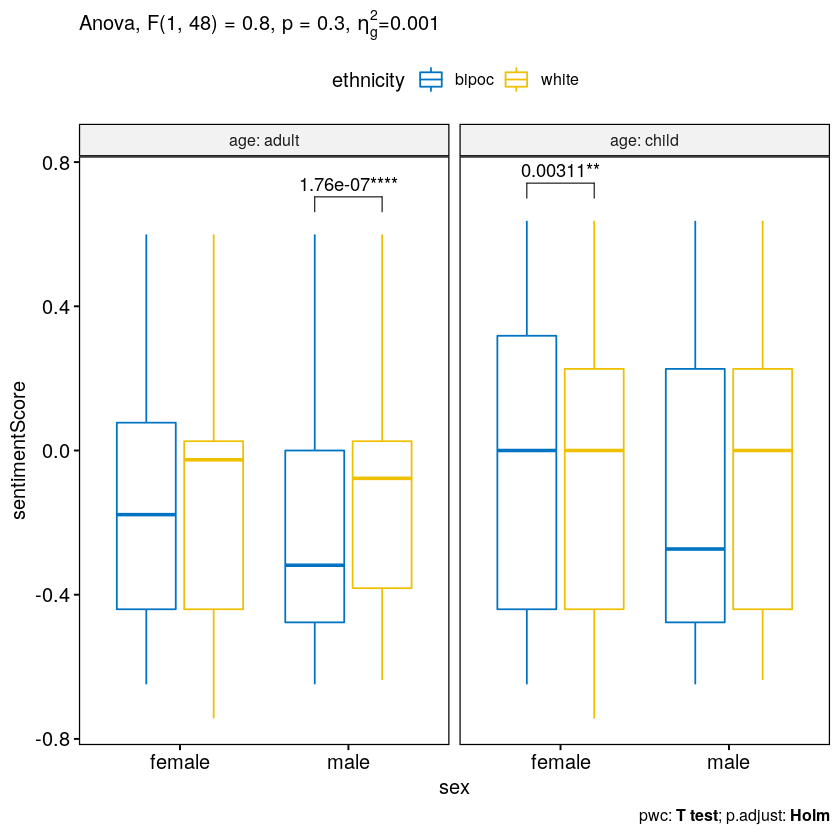

In [75]:
# subtitle_3way_anova = Anova, $F$(1, 48) = 0.76, $p$ = 0.3, $\eta^2_{g}=0.001$
subtitle_3way_anova_free = expression(paste("Anova, F(1, 48) = 0.8, p = 0.3, ",eta[g]^2, "=0.001"))
pwc <- pwc %>% add_xy_position(x = "sex")

bxp_free +  
  stat_pvalue_manual(
    pwc, hide.ns = TRUE, bracket.nudge.y = 0.1,
    label = "{p.adj}{p.adj.signif}"
    ) +
  labs(
    subtitle = subtitle_3way_anova_free,
    caption = get_pwc_label(pwc)
  )

In [76]:
ggsave("../clean_data/anova_3way_test_free_labeling.png")
ggsave("../../emotions_dashboard/data/anova_3way_test_free_labeling.png")

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

